# Fahrspurerkennung

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from Calibration import Calibration

## 0 Entzerrung

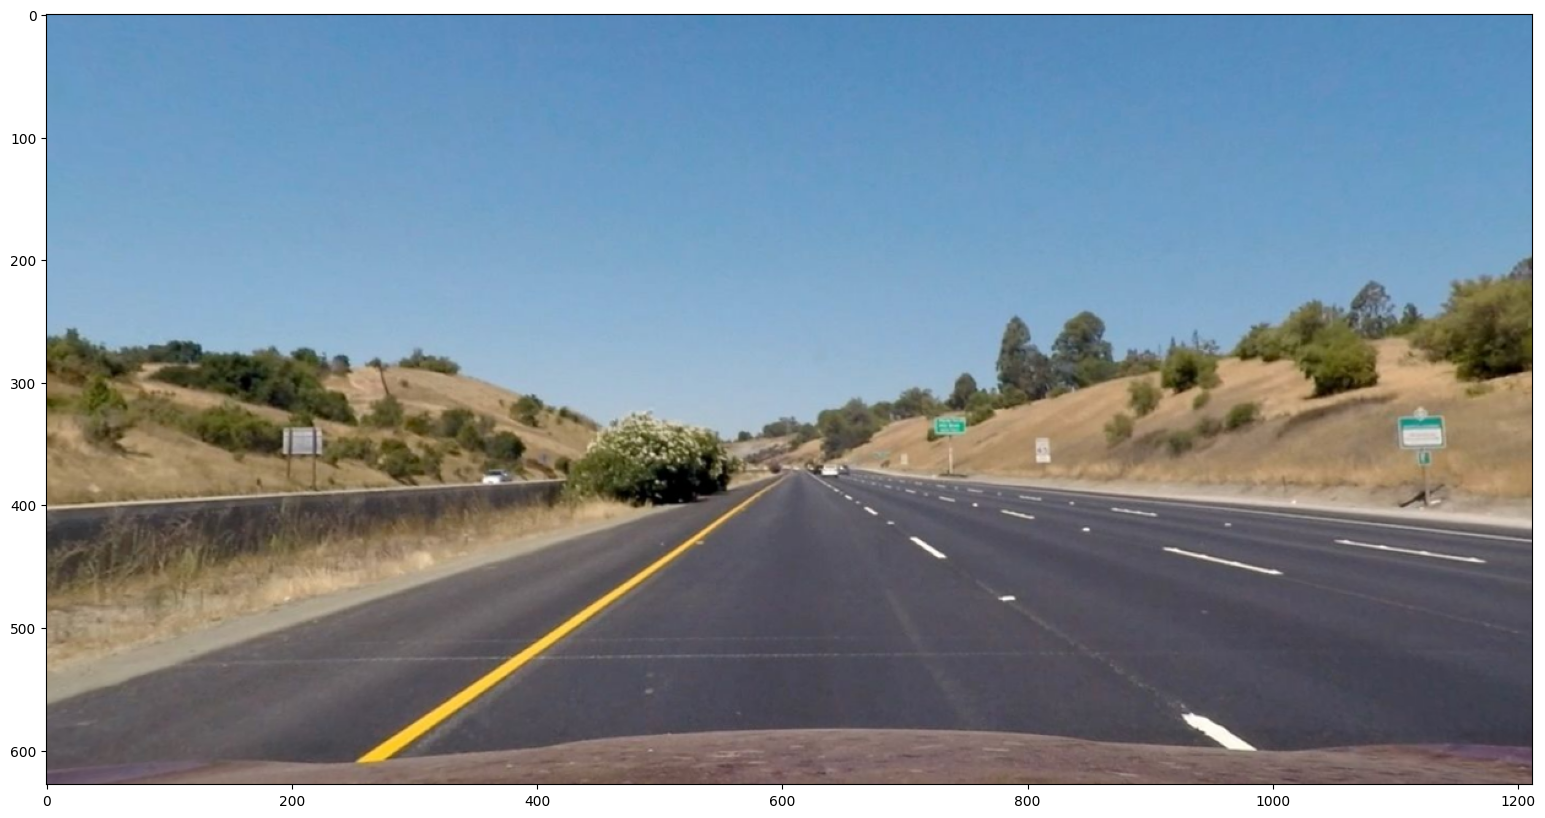

In [2]:
calib = Calibration()
imgs = [cv.imread(f"images/image00{i + 1}.jpg", cv.IMREAD_COLOR) for i in range(8)]
img = cv.imread("images/image001.jpg", cv.IMREAD_COLOR)
imgs = [cv.cvtColor(im, cv.COLOR_BGR2RGB) for im in imgs]
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgs = [calib.undistort(im) for im in imgs]
img = calib.undistort(img)

plt.figure(figsize=(20,10))
plt.imshow(imgs[0])
plt.show()

## 1. Region of Interest

## 1. Gelb → Weiß 

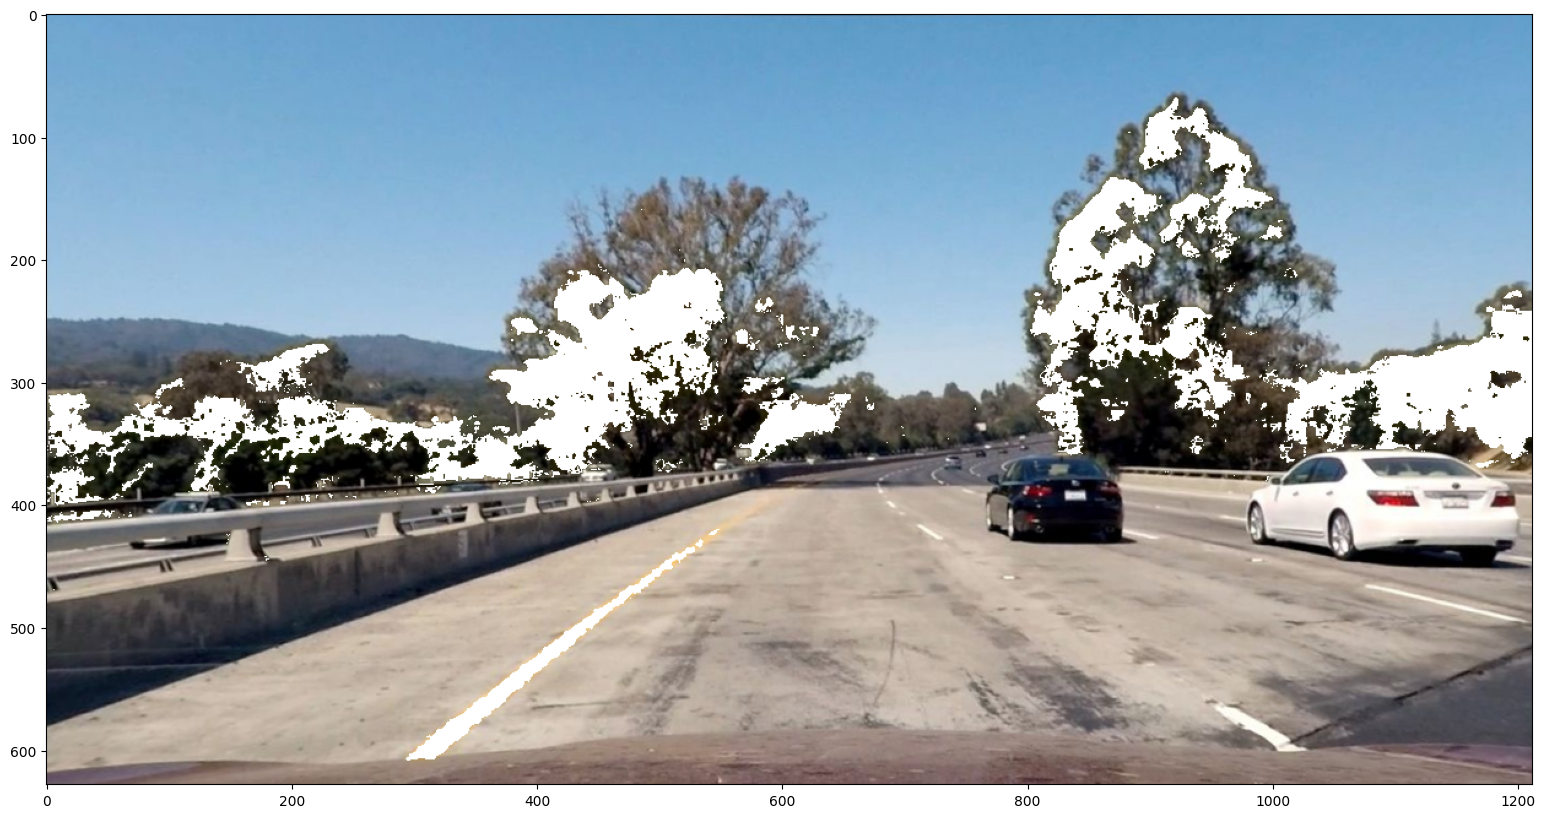

In [3]:

#imgs = [im[450:-1] for im in imgs]
#img = img[450:-1]


def yellow_to_white(img):
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    yellow_low = (20, 75 , 50)
    yellow_high = (40, 255, 255)
    img_yellow = cv.inRange(img_hsv, yellow_low, yellow_high)
    img_f = img.copy()
    img_f[np.where(img_yellow > 0)] = (255, 255, 255)
    return img_f

# yellow_low = (20, 75 , 75)
# yellow_high = (40, 255, 255)
# img_yellow = cv.inRange(img, yellow_low, yellow_high)
img_f = yellow_to_white(img)
img_fs = [yellow_to_white(im) for im in imgs]
# img_f[np.where(img_yellow > 0)] = (0, 0, 180)
# img_f = cv.cvtColor(img_f, cv.COLOR_HSV2RGB)


plt.figure(figsize=(20,10))
plt.imshow(img_fs[2])
plt.show()

## 2. Grauwertbild

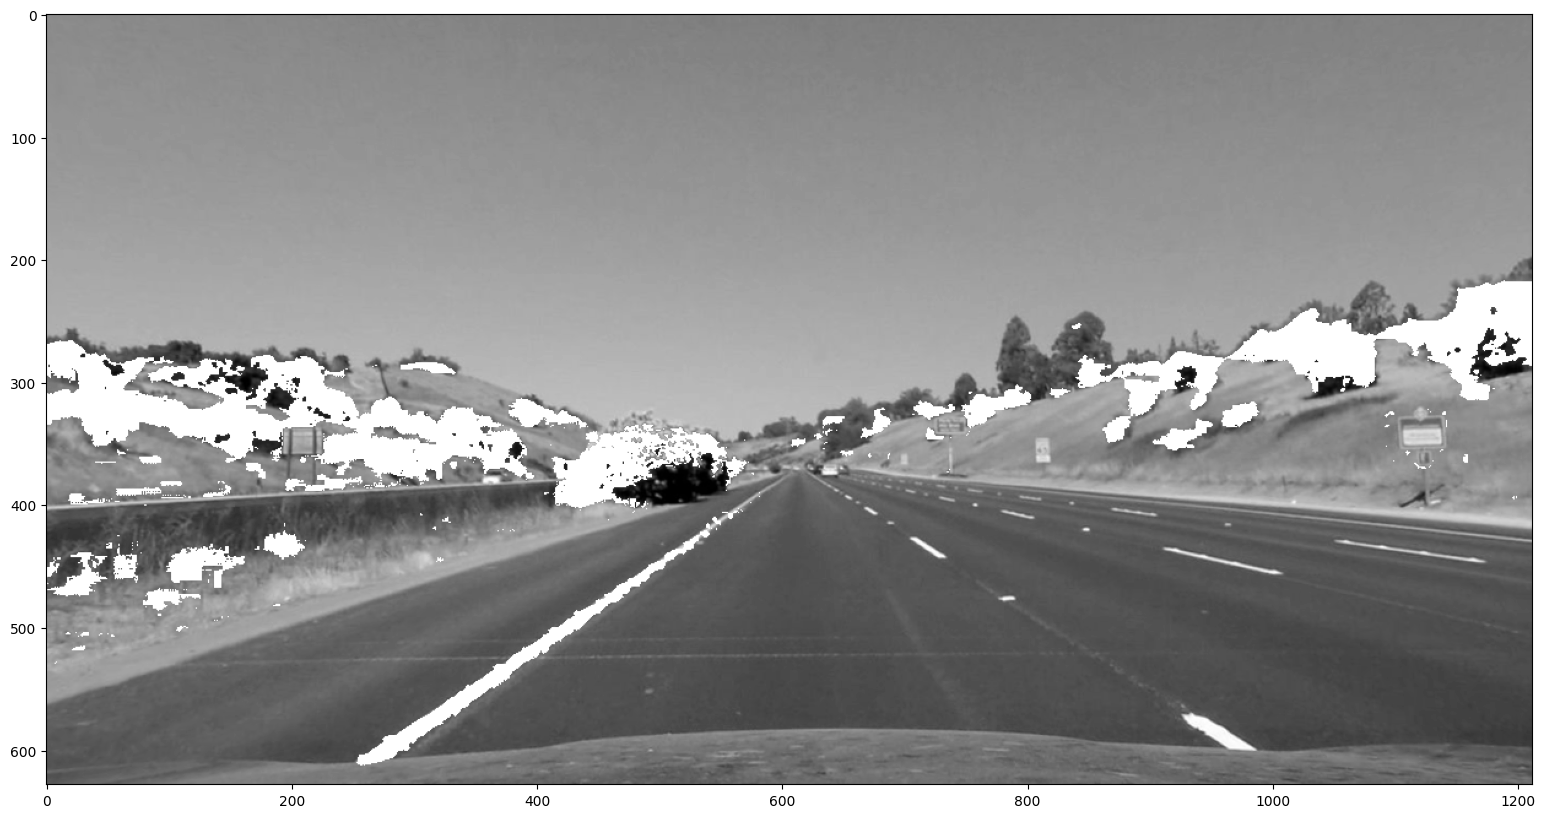

In [4]:
img_gray = cv.cvtColor(img_f, cv.COLOR_RGB2GRAY)
imgs_gray = [cv.cvtColor(im, cv.COLOR_RGB2GRAY) for im in img_fs]
# imgs_gray = [cv.equalizeHist(im) for im in imgs_gray]
# imgs_gray = [cv.adaptiveThreshold(im, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2) for im in imgs_gray]
for k, im in enumerate(imgs_gray):
    cv.imshow(f'image {k + 1}', im)
    cv.waitKey(0)
plt.figure(figsize=(20,10))
plt.imshow(img_gray, cmap='gray')
plt.show()

## 3. Kantenerkennung mit canny edge

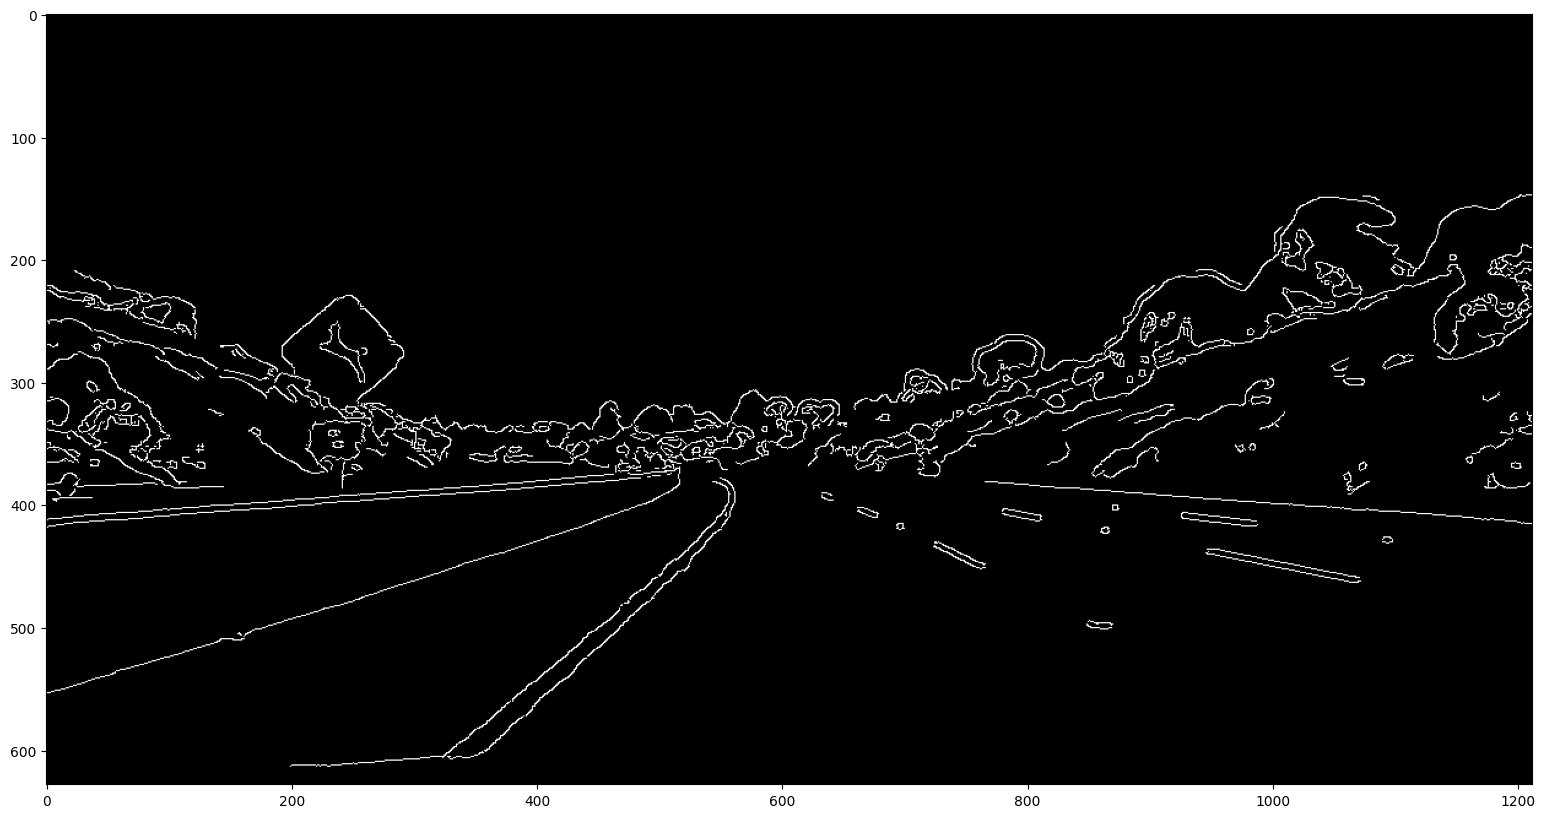

In [33]:
def gauss_and_canny(img):
    img_blurred = cv.GaussianBlur(img.copy(), (5,5), cv.BORDER_DEFAULT)
    return cv.Canny(img_blurred, 73, 145)

img_canny = gauss_and_canny(img_gray)
imgs_canny = [gauss_and_canny(im) for im in imgs_gray]

plt.figure(figsize=(20,10))
plt.imshow(imgs_canny[3], cmap='gray')
plt.show()

for k, im in enumerate(imgs_canny):
    cv.imshow(f'image {k + 1}', im)
    cv.waitKey(0)

## 4. Transformation in Birds-Eye-View

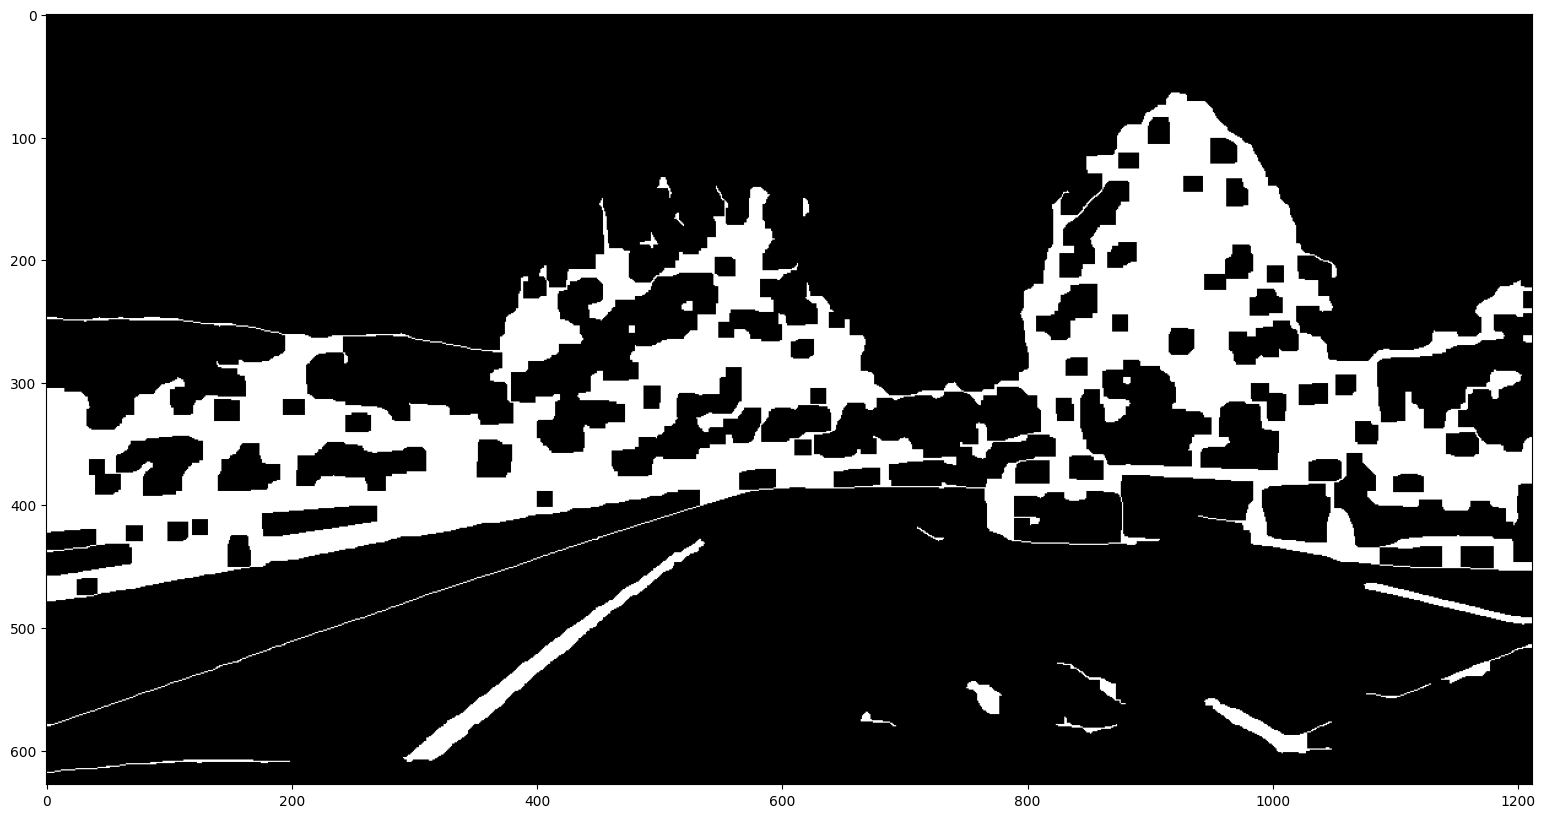

In [49]:
imgs_birdseye = [calib.warp_to_birdseye(im) for im in imgs_canny]
img_birdseye = calib.warp_to_birdseye(img_canny)

imgs_closed = [cv.morphologyEx(im, cv.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=3) for im in imgs_canny]
img_closed = cv.morphologyEx(img_birdseye, cv.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=10)

plt.figure(figsize=(20,10))
plt.imshow(imgs_closed[2], cmap='gray')
plt.show()

## 4. Hough-Transformation

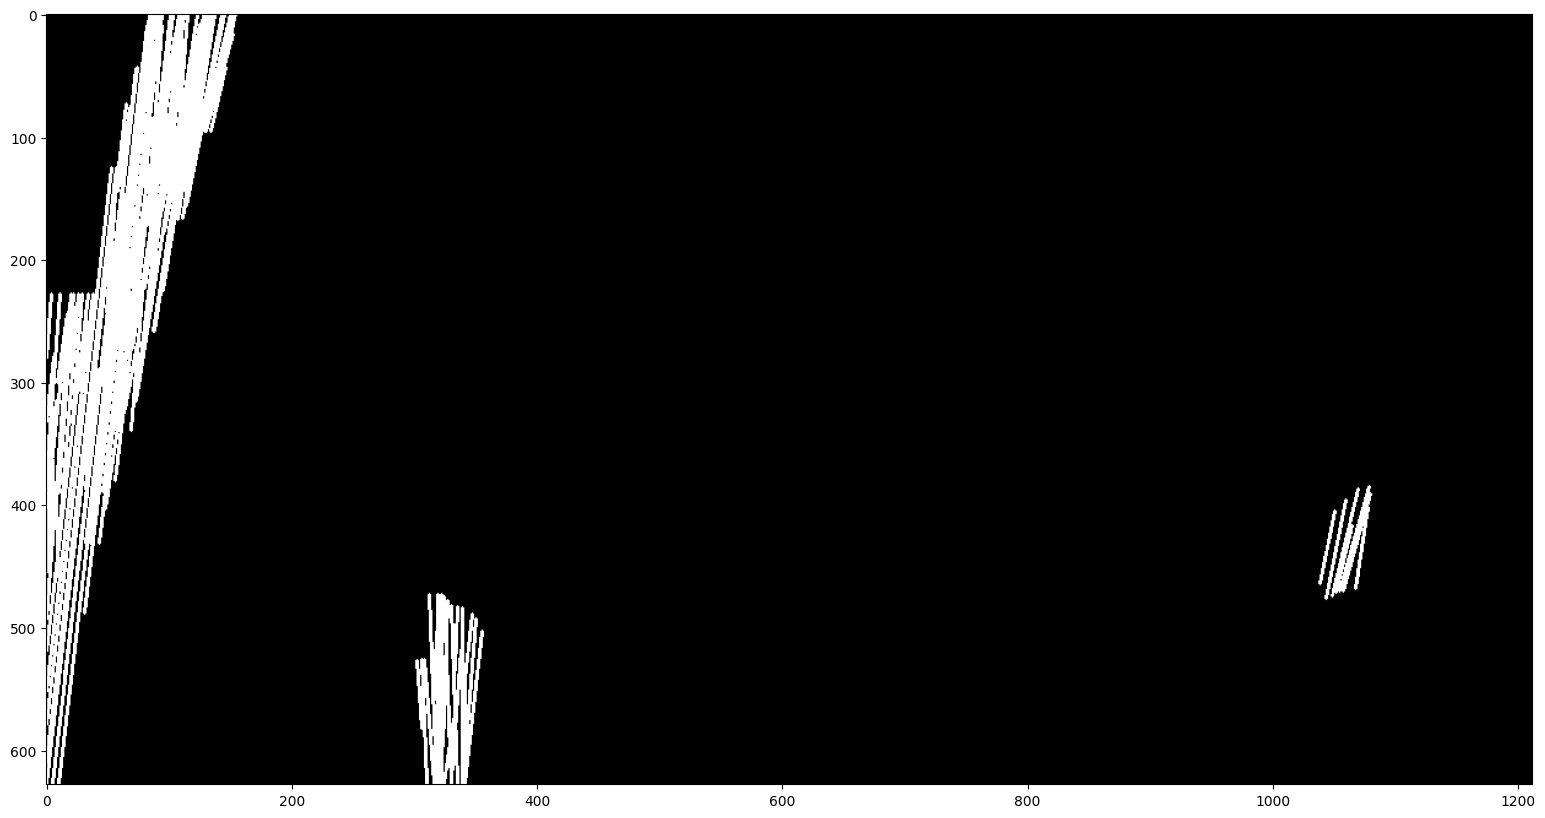

In [30]:
lines = cv.HoughLinesP(imgs_closed[2], rho=6, theta=np.pi/80, threshold=100, minLineLength=50, maxLineGap=0)
img_hough = imgs_closed[2].copy()

blank_img = np.zeros_like(img_hough)

x_acc = []
y_acc = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    x_acc.append(x1) if 100 < x1 < 640 and 100 < x2 < 640 else None
    x_acc.append(x2) if 100 < x1 < 640 and 100 < x2 < 640 else None
    y_acc.append(y1) if 100 < x1 < 640 and 100 < x2 < 640 else None
    y_acc.append(y2) if 100 < x1 < 640 and 100 < x2 < 640 else None
    cv.line(blank_img, (x1, y1), (x2, y2), (255, 255, 255), 2)


plt.figure(figsize=(20,10))
plt.imshow(blank_img, cmap='gray')
plt.show()

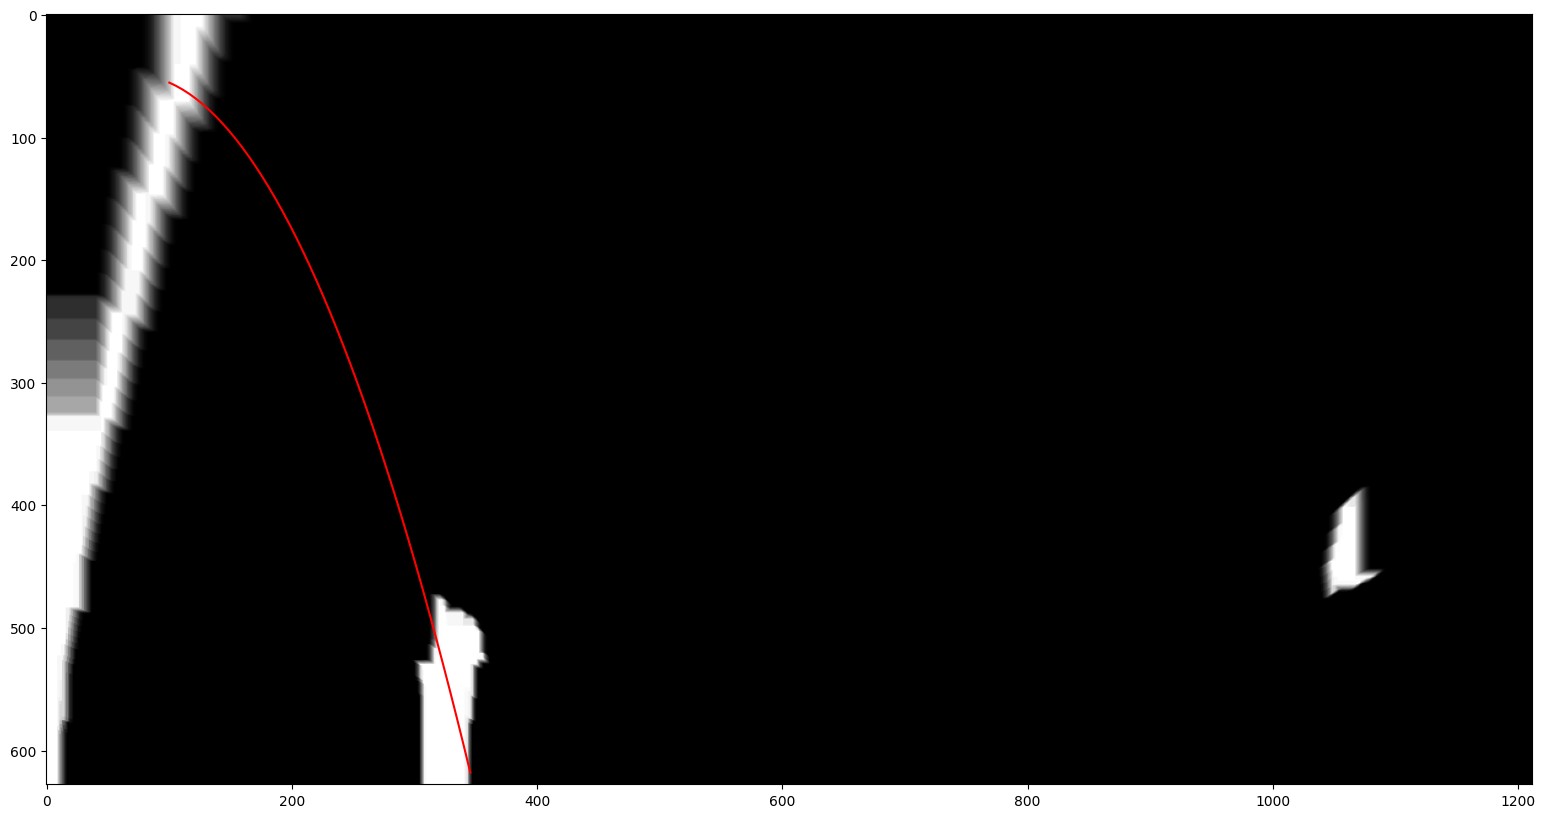

In [34]:
w2_2, w2_1, w2_0 = np.polyfit(x_acc, y_acc, 2)

x = np.linspace(100, 640, 100)
y = w2_2 * x**2 + w2_1 * x + w2_0

min_ind = np.searchsorted(y, 0)
max_ind = np.searchsorted(y, 640)

y = y[min_ind:max_ind]
x = x[min_ind:max_ind]
plt.figure(figsize=(20,10))
plt.imshow(img_hough, cmap='gray')
plt.plot(x, y, color='red')
plt.show()